In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time
import cv2

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 20*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
# %matplotlib notebook

2024-04-25 17:48:36.385977: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 17:48:36.475776: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 17:48:36.881177: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-04-25 17:48:36.881229: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-25 17:48:37.600371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 17:48:37.600540: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 17:48:37.600659: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 17:48:37.851923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-25 17:48:37.852107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [2]:
#load raw point cloud data from Newer College Dataset

#NEWER COLLEGE
idx = 8800 #1500 
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention used in VICET

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
## purple -> green
color = 255*np.linspace(0,1,len(pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

#remove NaNs
# pc1[pc1[:,0]>64] = 100
# pc1[pc1[:,0]<-64] = 100
# pc1 = np.nan_to_num(pc1, nan=0.0)

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

512.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to Depth Image

(64, 1024)


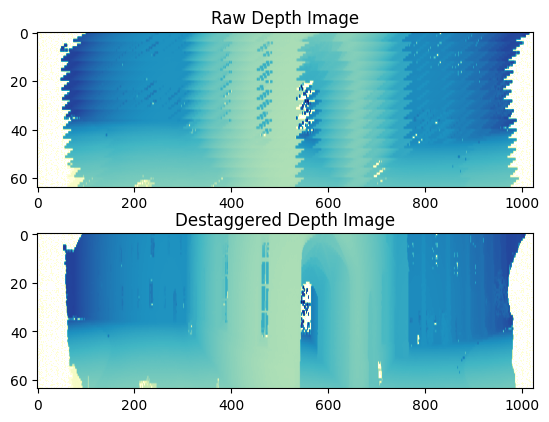

In [3]:
# %matplotlib notebook
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
pcs = np.reshape(pc1_spherical, [-1,64,3])
pcs = np.flip(pcs, axis = 1)
raw_data = pcs[:,:,0].T

# print(np.shape(data))

data = np.zeros([64, 1024])
for i in range(np.shape(data)[0]//4):
    #shift left
#     data[4*i,:-18] = raw_data[4*i,18:]
#     data[4*i+1,:-12] = raw_data[4*i+1,12:]
#     data[4*i+2,:-6] = raw_data[4*i+2,6:]
#     data[4*i+3,:] = raw_data[4*i+3,:]
#     #shift right
#     data[4*i,:] = raw_data[4*i,:]
#     data[4*i+1,6:] = raw_data[4*i+1,:-6]
#     data[4*i+2,12:] = raw_data[4*i+2,:-12]
#     data[4*i+3,18:] = raw_data[4*i+3,:-18]
    #keep centered-- avoids needing to fill in gaps
#     data[4*i,:-9] = raw_data[4*i,9:]
#     data[4*i+1,:-3] = raw_data[4*i+1,3:]
#     data[4*i+2,3:] = raw_data[4*i+2,:-3]
#     data[4*i+3,9:] = raw_data[4*i+3,:-9]
    data[4*i,1:-8] = raw_data[4*i,9:]
    data[4*i+1,1:-2] = raw_data[4*i+1,3:]
    data[4*i+2,4:] = raw_data[4*i+2,:-4]
    data[4*i+3,10:] = raw_data[4*i+3,:-10]
    
# data = np.flip(data, axis =1)

fig, ax = p.subplots(2,1)
ax[0].set_title("Raw Depth Image")
ax[0].imshow(raw_data, cmap = "YlGnBu", norm='log')
ax[0].set_aspect(5)
ax[1].set_title("Destaggered Depth Image")
ax[1].imshow(data, cmap = "YlGnBu", norm='log')
ax[1].set_aspect(5)
print(np.shape(data))


# Reproject 2D Depth image back to 3D point cloud

#### IMPORTANT: look into pixel_shift_by_row parameter from OUSTER
https://ouster.com/insights/blog/firmware-2-4-industry-standard-protocols-and-improved-alerts

In [4]:
#OS1 LiDAR Intrinsics
#as specified in datasheet
# phimin = np.deg2rad(-16.6) #supposed to be this
# phimax = np.deg2rad(16.6)
#angles required to reproduce observed point clouds
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
depth_img  = data.T

new_point_cloud_spherical = np.zeros([np.shape(pcs)[0]*np.shape(pcs)[1],3])
pc1_spherical = new_point_cloud_spherical

count = 0
for w in range(np.shape(depth_img)[0]):
    for h in range(np.shape(depth_img)[1]):
        new_point_cloud_spherical[count,0] = depth_img[w,h] #radius
        new_point_cloud_spherical[count,1] = 2*np.pi*(w/np.shape(depth_img)[0]) #theta
        new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth_img)[1]) #phi
        count+= 1

new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#shape image to have same angular field of view in width and height
vert_fov = np.rad2deg(phimax-phimin)
# print(vert_fov)
# vert_fov/360
# print((vert_fov/360)*np.shape(pcs)[0])

In [5]:
print(max(pc1_spherical[:,0]))

128.94100702003772


In [6]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

## purple -> green
color = 255*np.linspace(0,1,len(new_point_cloud_cart)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(new_point_cloud_cart, c=cname,  r = 3.5, alpha =0.5))
# disp.append(Points(new_point_cloud_cart[::32], c='red',  r = 3.5, alpha =0.8))
# disp.append(Points(new_point_cloud_cart[::4], c='blue',  r = 5., alpha =0.125))

disp.append(Points(pc1, c = 'blue', r = 3.5, alpha = 0.5))

plt.show(disp, "Raw Point Cloud")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Load ground truth poses (map frame) and convert to NeRF LH Coordinate System

(-150.0, 30.0)

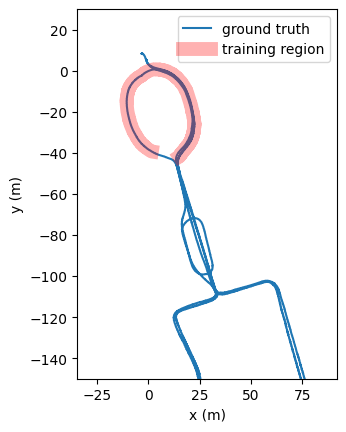

In [7]:
from os import listdir

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
# print(np.shape(gt))
# print(gt[20,:])

scan_dir = dir_name + experiment_name + "raw_format/ouster_zip_files/ouster_scan-007/ouster_scan/"
list_of_all_scans = sorted(listdir(scan_dir))

#plot ground truth trajectory
fig, ax = p.subplots()
ax.set_aspect('equal')
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.plot(gt[:,2], gt[:,3], label = "ground truth")

#superimpose trajectory from <short_experiment_01>
# first_timestamp = int(list_of_all_scans[0][6:16])
# last_timestamp = int(list_of_all_scans[-1][6:16]) #scrape timestamp from name of velodyne .pcl file
# first_idx = np.argwhere(gt[:,0] == first_timestamp)[0][0]
# last_idx = np.argwhere(gt[:,0] == last_timestamp)[0][0]
first_idx = 7700 #1500 #1450 #700
last_idx = 8700 #2100 #1950 #1000

ax.plot(gt[first_idx:last_idx,2], gt[first_idx:last_idx,3], 'r', lw = 10, alpha = 0.3, label = 'training region')
ax.legend(loc = 'best')
ax.set_ylim([-150,30])

In [ ]:
from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 50 #20 
n_rots = 8 #8 
#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
#just for debug
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)
# phimin = -0.53529248 #rad
# phimax = 0.18622663 #rad
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots,4,4])
images = np.ones([n_images*n_rots, 64, 64, 2]) #depth image and raydrop

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
H, W = images.shape[1:3]
print(focal, H, W)

for i in range(n_images):
    #load point cloud
    idx = i*10 + 600 #1450 #700    
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    #convert to depth image
    pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1)

#     print(np.shape(data))
#     print(np.shape(pc1_spherical))

    for j in range(n_rots):
        
        #get cropped depth image ~~~~~~~~~~~~~~~~~~~~
#         pcs = np.flip(data, axis = 1) #flip vertical
#         pcs = np.flip(pcs, axis = 0) #flip horizontal to look at first clockwise patch of scan sweep 
#         pcs = pcs.T
        pcs = data.T
        
        #resize image to 64x64
        image_width = int((vert_fov/360)*np.shape(pcs)[0])        
#         pcs = pcs[j*image_width:(j+1)*image_width,:].T #SQUARE
        pcs = pcs[(j+1)*image_width:(j+2)*image_width,:].T #SQUARE-- skip beginning of frame (blocked by human)
#         pcs = pcs[(j*image_width//32):((j+1)*image_width//32),:,0].T #32nds
        pcs = cv2.resize(pcs, (64, 64), cv2.INTER_NEAREST) #keep square
        #TEST
#         pcs = np.flip(pcs, axis =1)
    
        #preserve aspect ratio and focal length but just take middle
#         pcs = pcs[:,31:33] #uncomment for 32nds
        images[j+(i*n_rots),:,:,0] = pcs #save depth information to first channel
        a = np.argwhere(pcs == 0)
        #TODO: why do some distant windows register as being close (but not non-returns)??
        images[j+(i*n_rots),a[:,0],a[:,1],1] = 0 #save raydrop mask to 2nd channel
        
        #get transformation matrix ~~~~~~~~~~~~~~~~~~
        rotm = np.eye(4)
        rotm[1,3] = -gt[idx,2] #x
        rotm[2,3] = gt[idx,3] #y
        rotm[0,3] = -gt[idx,4] #z
        rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

# #         #orient yellow (-z) pointing forward
        fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
        fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2

        #unreliable?
        temp = R.from_matrix(rotm[:3,:3]).as_euler('zxy')
        rotm[:3,:3] = R.from_euler('xyz', [temp[0], temp[1], -temp[2]]).as_matrix()
                
        #account for image crop in rotation
        #swapping sign convention from what was used in synthetic data(?) ...+j*(phimax-phimin)
#         crop_angle = 0 #DEBUG ONLY
#         crop_angle = -(phimax-phimin)/2 + j*(phimax-phimin) #square
        crop_angle = -(phimax-phimin)/2 + (j+1)*(phimax-phimin) #square-- but skip beginning of frame
        #         crop_angle = -(phimax-phimin)/64 - j*(phimax-phimin)/32 #2-pixels wide
        
        #account for the fact that sensor points back and to the left
        crop_angle -= np.pi/4 
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix() #looks better
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() #was this
#         sensor_elevation_zero_rotm = R.from_euler('xyz', [0,(phimin+phimax)/2,0]).as_matrix() #TODO: not sure if rot about y or z
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm

        #flip x and z axis
#         rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 
#         rotm[0,-1], rotm[1,-1] = rotm[1,-1], rotm[0,-1]  #test

# #         # flip sign of axis
#         rotm[0:3,2] *= -1 #was this
#         rotm[0:3,1] *= -1 #was this
#         rotm[0:3,0] *= -1 #test
#         rotm = rotm[[1,0,2,3],:] #was this
#         rotm = rotm[[2,0,1,3],:]
#         rotm[2,:] *= -1 # flip whole world upside down
#         #translate all frames above xy plane
        rotm[2,-1] += 45 
        
        #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
        rotm[:3,-1] *= 0.05
        images[j+(i*n_rots),:,:,0] *= 0.05
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        poses[j+(i*n_rots)] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)
        
# test on one only
testimg, testpose = images[(n_images*n_rots)-1], poses[(n_images*n_rots)-1]
images = images[:((n_images*n_rots)-1),...,:3]
poses = poses[:((n_images*n_rots)-1)]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

In [ ]:
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

# ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

# Debug: draw frames

In [ ]:
#Raw frames, in Newer College RHCS convention
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

# new_point_cloud_spherical = np.zeros([np.shape(images)[1]*np.shape(images)[2],3])

for i in range(30):
    idx = i*20 + 600    
    
    rotm = np.eye(4)
    rotm[0,3] = gt[idx,2] #x
    rotm[1,3] = gt[idx,3] #y
    rotm[2,3] = gt[idx,4] #z
    rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 
    
    #draw frames for each sub-scan 
    alph = 1-(i/30)
    #forward view direction (-z in NeRF c2w convention)
    headings = rotm[:3,:3] @ np.array([0,0,-1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = rotm[:3,:3] @ np.array([1,0,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = rotm[:3,:3] @ np.array([0,1,0])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = rotm[:3,:3] @ np.array([0,0,1])
    disp.append(Arrows(rotm[:3,-1][None,:], (rotm[:3,-1] + headings)[None,:], c = "blue", alpha = alph))

disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Actual Ground Truth Path (Newer College Frame)")
ViewInteractiveWidget(plt.window)

In [ ]:
#DEBUG-- find appropriate cutoff threshold for structural regularization loss
thresh_horiz = 0.001 #0.1
thresh_vert = 0.01 #1.
idx = 19

fig, ax = p.subplots(3)
# ax[0].imshow(data, aspect = 5)
ax[0].imshow(images[idx,:,:,0], aspect = 1)

# mask = np.zeros(np.shape(data[:,:]))
mask = np.zeros(np.shape(images[idx,:,:,0]))
# vertical_grad_target = np.gradient(data[:,:])[0] 
vertical_grad_target = np.gradient(images[idx,:,:])[0] 
# print(data[:5,:2])
# print("\n",vertical_grad_target[:5,:2])
vertical_grad_target = np.gradient(vertical_grad_target)[0] #test for double gradient 
# print("\n",vertical_grad_target[:5,:2])
vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target) > thresh_vert)
mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 1

# horizontal_grad_target = np.gradient(data[:,:])[1]
horizontal_grad_target = np.gradient(images[idx,:,:])[1]
horizontal_grad_target = np.gradient(horizontal_grad_target)[1] #test for double gradient 
horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target) > thresh_horiz)
mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 1

ax[1].imshow(mask[:,:], aspect=1)
ax[2].imshow(images[idx,:,:,1])

## Train Network

In [ ]:
#DEBUG-- I don't think embed function is actually doing anything???
pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals
#[image height, image width, n_samples, 3]
print("pts", np.shape(pts))

# Run network to estimate densities and ray drop 
pts_flat = tf.reshape(pts, [-1,3])
print("before: ", np.shape(pts_flat), "\n", pts_flat[0].numpy(),)

# print(tf.sin(pts_flat[0]))

pts_flat = embed_fn(pts_flat)
# print(np.shape(pts_flat))
print("\n after: ", np.shape(pts_flat), "\n", pts_flat[0].numpy(),)


In [ ]:
print("rays_d", np.shape(rays_d))
# print(np.shape(rays_d[...,None,:]))
print("z_vals", np.shape(z_vals))

test = rays_d[...,None,:]* z_vals

print(np.shape(test))
# print(rays_d[5,0,:])
# print(test[5,0,-1,:])

# print(z_vals[0,0,:,0])

# print(np.sqrt(np.sum(rays_d[30,0,:]**2))) #actually all 1.0 (correct)

# print(np.max(pts_flat))

In [ ]:
# print(3 + 3*2*5) # ---> 33 (was this)

#why am I getting 102??
# 63 + 39????
# print(3*2*4 + 3*2*10)
print(6 + 3*2*5 + 3*2*11)

In [ ]:
# def posenc(x, embed_dims):
#   rets = [x]
#   for i in range(embed_dims):
#     for fn in [tf.sin, tf.cos]:
#       rets.append(fn(2.**i * x))
#   return tf.concat(rets, -1)

# #2**18 is waaaaay too fine to learn anything on most of the channels!
# # L_embed =  5 #18 #15 #10 #6
# embed_fn = posenc

# def init_model(D=8, W=256): #8,256
# #     relu = tf.keras.layers.ReLU() #OG NeRF   
#     relu = tf.keras.layers.LeakyReLU() #per LOC-NDF   
#     dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act, kernel_initializer='glorot_uniform')

# #     inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) #old (embed everything together)
#     inputs = tf.keras.Input(shape=(6 + 3*2*5 + 3*2*11)) #new
#     outputs = inputs
#     for i in range(D):
#         outputs = dense()(outputs)
#         #test-- add layer normalization
#         outputs = tf.keras.layers.LayerNormalization()(outputs)
        
#         if i%4==0 and i>0:
#             outputs = tf.concat([outputs, inputs], -1)

#     #extend "color" channels to small MLP after output of density channel
#     sigma_channel = dense(1, act=None)(outputs)
    
#     rd_start = tf.concat([outputs, inputs], -1)
# #     rd_channel = dense(128, act=relu)(outputs) #was this
#     rd_channel = dense(256, act=relu)(outputs) #test matching OG NeRF structure
#     rd_channel = dense(128, act=relu)(rd_channel)
#     rd_channel = dense(1, act=tf.keras.activations.sigmoid)(rd_channel)
#     out = tf.concat([sigma_channel, rd_channel], -1)
#     model = tf.keras.Model(inputs=inputs, outputs=out)
    
#     return model

# def get_rays(H, W, c2w, phimin_patch, phimax_patch):
#     i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')

#     phimin = np.deg2rad(-16) 
#     phimax = np.deg2rad(17.75)

#     #~~~~~~~~~~~~~~~~~~~~~~~~~
# #     #Cylindrical projection model (new)
# #     #only seems to draw well with single vertical patch
# #     dirs_test = tf.stack([-tf.ones_like(i), #r
# #                       #theta
# #                       (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots) + np.pi, #for uninterpolated images
# #                       #phi
# #                       (phimax_patch + phimin_patch)/2 - ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_patch-phimin_patch) 
# #                      ], -1)
# #     dirs_test = tf.reshape(dirs_test,[-1,3])
# # #     dirs_test = LC.s2c(LC, dirs_test)    #was this
# # #     dirs_test = spherical_to_cartesian(dirs_test)  #does the same thing
# #     dirs_test = cylindrical_to_cartesian(dirs_test)  #test
    
#     #~~~~~~~~~~~~~~~~~~~~~~~~~
#     #Spherical projection model (old)
#     #[r, theta, phi]
#     dirs_test = tf.stack([-tf.ones_like(i), #r
#                           #theta
# #                           ((i-32)/64)*(phimax-phimin), #for square images (FOV_vert==FOV_horiz)
# #                           (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots), #for uninterpolated images
#                             (i - (W//2))  /(W) * (2*np.pi/(1024//W)), #just use W
#                           #phi
#                           #need to manually account for elevation angle of patch 
#                           #  (can not be inferred from c2w since that does not account for singularities near "poles" of spherical projection)
#                           (phimax_patch + phimin_patch)/2 + ((-j+(H/2))/(H))*(phimax_patch-phimin_patch) -np.pi/2
#                          ], -1)
#     dirs_test = tf.reshape(dirs_test,[-1,3])
#     dirs_test = LC.s2c(LC, dirs_test)     

#     #~~~~~~~~~~~~~~~~~~~~~~~~~
    
#     rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix()
#     dirs_test = dirs_test @ rotm
#     dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])
#     dirs = dirs_test @ (c2w[:3,:3] 
#                           @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix()
#                           @ np.linalg.pinv(c2w[:3,:3]) )

#     dirs = tf.reshape(dirs, [H,W,3])

#     rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * np.eye(3), -1)     
        
#     rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
#     return rays_o, rays_d

# #new method (pass in sample locations)
# def render_rays(network_fn, rays_o, rays_d, z_vals):
    
#     def batchify(fn, chunk=1024*512): #1024*512 converged for v4 #1024*32 in TinyNeRF
#         return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

# #     #Old version (pass in pts directly, no seperation of positions and directions) ~~~~~~
# #     #[image_height, image_width, batch_size, 3]
# #     pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals
# #     # Run network to estimate densities and ray drop 
# #     pts_flat = tf.reshape(pts, [-1,3])
# #     pts_flat = embed_fn(pts_flat)
# #     raw = batchify(network_fn)(pts_flat)
# #     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#     #New version-- encode both positions and directions ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#     ray_pos = rays_o[...,None,:] + rays_d[...,None,:] * z_vals
#     ray_pos = tf.reshape(ray_pos, [-1, 3])
#     encoded_ray_pos = embed_fn(ray_pos, 10) #10 embedding dims for pos
#     ray_dir = tf.reshape(rays_d[..., None,:]*tf.ones_like(z_vals, dtype = tf.float32), [-1,3]) #test
#     encoded_ray_dir = embed_fn(ray_dir, 6)  # embedding dims for dir

# #     print("ray_pos", np.shape(ray_pos))
# #     print("ray_dir", np.shape(ray_dir))
# #     print("encoded_ray_pos", np.shape(encoded_ray_pos))
# #     print("encoded_ray_dir", np.shape(encoded_ray_dir))
    
#     encoded_both = tf.concat([encoded_ray_pos, encoded_ray_dir], axis = -1)
# #     print("encoded_both", np.shape(encoded_both))
#     raw = batchify(network_fn)(encoded_both) #old

# #     print("raw", np.shape(raw))
    
#     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# #     print("problem here: ", list(pts.shape[:-1]) + [2])    
# #     raw = tf.reshape(raw, list(pts.shape[:-1]) + [2]) # [depth, ray drop] #old

#     raw = tf.reshape(raw, [pts.shape[0],pts.shape[1],-1,2]) # test -- doesn't allow upscaling when rendering?
# #     print("raw", np.shape(raw))
    
#     sigma_a = tf.nn.relu(raw[...,0])
#     ray_drop = tf.nn.relu(raw[...,1])
    
#     # Do volume rendering with unique z vals for each ray
#     dists = tf.concat([z_vals[:,:,1:,:] - z_vals[:,:,:-1,:], tf.broadcast_to([1e10], z_vals[:,:,:1,:].shape)], -2) 
#     dists = dists[:,:,:,0]

#     print("sigma_a", np.shape(sigma_a))
#     print("dists", np.shape(dists))
    
#     alpha = 1.-tf.exp(-sigma_a * dists)  
#     weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
#     depth_map = tf.reduce_sum(weights * z_vals[:,:,:,0], -1)
#     ray_drop_map = tf.reduce_sum(weights * ray_drop, -1) #axis was -2, changed to -1 
#     acc_map = tf.reduce_sum(weights, -1)
    
#     return depth_map, acc_map, ray_drop_map, weights

# def calculate_loss(depth, ray_drop, target, target_drop_mask):
#     """L_total = L_dist + lam1*L_intensity + lam2*L_raydrop + lam3*L_reg"""

#     #ray drop loss
#     L_raydrop = tf.keras.losses.binary_crossentropy(target_drop_mask, ray_drop)
#     L_raydrop = tf.math.reduce_mean(tf.abs(L_raydrop))

#     #distance loss (suppressing ray drop areas)
#     depth_nondrop = tf.math.multiply(depth, target_drop_mask)
#     target_nondrop = tf.math.multiply(target, target_drop_mask)
#     L_dist = tf.reduce_mean(tf.abs(depth_nondrop - target_nondrop))
    
#     #Gradient Loss (structural regularization for smooth surfaces)
# #     thresh = 0.025 #was at 0.025, set to 0.1 in LiDAR-NeRF
#     ##--seems like this works better if I set different values for each component
#     #    this makes sense since the resolution of the sensor is differnt in horizontal and vertical(?)
#     thresh_horiz = 0.001 
#     thresh_vert = 0.01
#     mask = np.zeros(np.shape(target[:,:,0]))
#     vertical_grad_target = np.gradient(target[:,:,0])[0] 
#     #test for double gradient 
#     vertical_grad_target2 = np.gradient(vertical_grad_target)[0] 
#     vertical_past_thresh = np.argwhere(tf.abs(vertical_grad_target2) > thresh_vert)

#     mask[vertical_past_thresh[:,0], vertical_past_thresh[:,1]] = 1
#     horizontal_grad_target = np.gradient(target[:,:,0])[1]
#     #test for double gradient
#     horizontal_grad_target2 = np.gradient(horizontal_grad_target)[1]  
#     horizontal_past_thresh = np.argwhere(tf.abs(horizontal_grad_target2) > thresh_horiz)
#     mask[horizontal_past_thresh[:,0], horizontal_past_thresh[:,1]] = 1
    
#     vertical_grad_inference = np.gradient(depth[:,:,0])[0]
#     horizontal_grad_inference = np.gradient(depth[:,:,0])[1]
#     mag_difference = tf.math.sqrt((vertical_grad_target-vertical_grad_inference)**2 + (horizontal_grad_target-horizontal_grad_inference)**2)
#     #DEBUG -- use struct reg. to amplify LR in sharp corners 
# #     mag_difference = tf.reduce_mean(tf.abs(depth_nondrop - target_nondrop)) 

#     #suppress ray drop areas (for distance and gradient loss)
#     L_reg = np.multiply(mag_difference, mask)
#     L_reg = L_reg[:,:,None]
#     L_reg = tf.reduce_mean(tf.math.multiply(L_reg, target_drop_mask))
#     L_reg = tf.cast(L_reg, tf.float32)            

#     lam1 = 1 #100
#     lam2 = 1 #1/(64**2)
#     loss = L_dist + lam1*L_reg + lam2*L_raydrop       

#     return(loss)

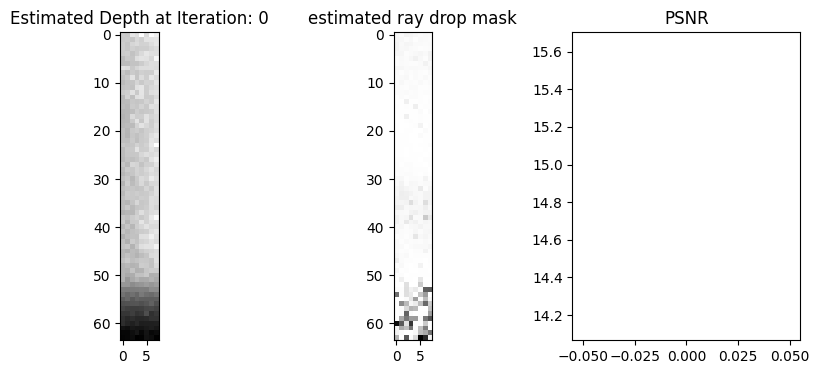


KeyboardInterrupt



In [61]:
from lidar_nerf_utils import *

# model = init_model()
# optimizer = tf.keras.optimizers.Adam(5e-4) #default tiny-NeRF
optimizer = tf.keras.optimizers.Adam(5e-5) #anneal to this (LiDAR NeRF)
# optimizer = tf.keras.optimizers.Adam(5e-6) #anneal to this (Mip-NeRF)

from numpy.lib.stride_tricks import sliding_window_view

N_samples = 128 #128
near=0.
far=2.
N_iters = 5_000_000
psnrs = []
iternums = []
i_plot = 100

#IMPORTANT-- this needs to match values used when setting up training data 
n_rots = 128 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #8 #number of vertical patches between phimin and phimax
H = 64 // n_vert_patches
W = 1024 // n_rots

phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)

for i in range(N_iters+1):
#     print(i)
    img_i = np.random.randint(images.shape[0])
    target = images[img_i,:,:,:1]
    target_drop_mask = images[img_i,:,:,1:]
    pose = poses[img_i]
    
    #old
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
# #     #test -- send bins from top to bottom
#     phimin_patch = vertical_bins[len(vertical_bins) -1 - (img_i%n_vert_patches+1)] 
#     phimax_patch = vertical_bins[len(vertical_bins) -1 - (img_i%n_vert_patches)]
    
    #get ray origins and ray directions
    rays_o, rays_d = get_rays(H, W, pose, phimin_patch, phimax_patch)
    
    with tf.GradientTape() as tape:

        # run coarse network~~~~~~~~~~~~~~~~~
        z_vals = tf.linspace(near, far, N_samples)  #IMPORTANT NOTE: z_vals must be in ascending order 
#         z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples #test
        z_vals = z_vals[:,:,:,None]#manually expand dimensions before passing in to coarse network (all pixels will share the same z_vals)
        depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        loss_coarse = calculate_loss(depth, ray_drop, target, target_drop_mask)
        
        # run fine network ~~~~~~~~~~~~~~~~~~
        #pad weights with zeros
        fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
        rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
        #use additional axis to calculate all at once
        fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
        rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
        
        #blur-pool as vectorized operation
        test2 = (fwd_test + rev_test) /2 #blur
#         test2 += 1/N_samples #shift up slightly
        test2 += 1/(3*N_samples) #shift up slightly
        test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
        
        cum_hist_vals = np.cumsum(test2, axis = -1)
        randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
        cum_hist_vals_flat = cum_hist_vals.flatten()

        #modify cum_hist_vals so it is monotonically increasing (needed for interp func to work)
        step_corr = np.linspace(0,W*H-1,W*H)
        step_corr = np.tile(step_corr,(N_samples,1)).T
        step_corr = np.reshape(step_corr, [1,-1])[0,:]
        cum_hist_vals_flat+= step_corr

        linear_spaced = np.linspace(near, H*W, N_samples*H*W)
        ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
        ans -= step_corr
        ans *= far #scale back to max value
        ans = np.abs(ans)
        z_vals = np.reshape(ans, [H,W,N_samples,1])
        
        depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        loss_fine = calculate_loss(depth, ray_drop, target, target_drop_mask)
        # ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        loss = 0.1*loss_coarse + 0.9*loss_fine 
#         loss = loss_fine 
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, testpose, vertical_bins[-2], vertical_bins[-1]) #constant validation image
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
        depth = depth[:,:,None]
        ray_drop = ray_drop[:,:,None]
        target = testimg[:,:,:1]
        target_drop_mask = testimg[:,:,1:]
        loss = calculate_loss(depth, ray_drop, target, target_drop_mask)
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        iternums.append(i)
        p.figure(figsize=(10,4))
        p.subplot(131)
        p.imshow(depth,cmap = "gray")#, norm='log')
        p.title(f'Estimated Depth at Iteration: {i}')
#         p.imshow(testimg[:,:,1],cmap = "gray") #, norm='log')
#         p.title(f'Actual Mask at Iteration: {i}')
        p.subplot(133)
        p.plot(iternums, psnrs)
        p.title('PSNR')
        #look at depth map
        p.subplot(132)
        p.imshow(ray_drop, cmap="gray")#, norm = 'log')
        p.title("estimated ray drop mask")
        p.show()
print('Done')

In [52]:
# # inputs = tf.zeros([1,72])
# # print(np.shape(inputs))
# # test = inputs[:,:(3+3*2*(8))]
# # print(np.shape(test))
# inputs = tf.zeros([1,90])
# print(np.shape(inputs))
# test = inputs[:,:(3+3*2*(10))]
# print(np.shape(test))

# # print(6 + 3*2*(3) + 3*2*(8))
# print(model.summary())

took 0.005332231521606445 s
z_vals (64, 8, 128, 1)


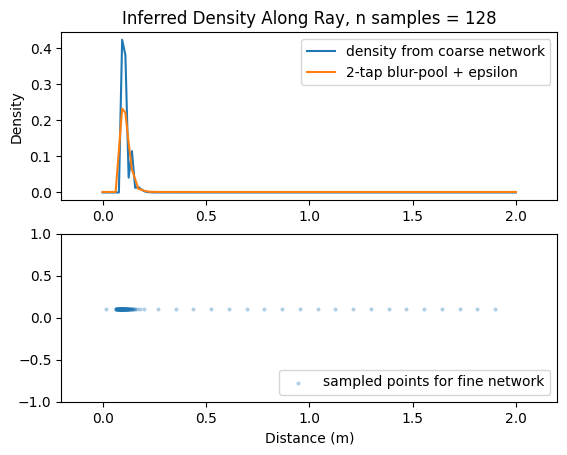

In [53]:
#Use density of returns along each ray in a coarse netowork to select test points for fine network
from scipy.stats import norm
from scipy.interpolate import interp1d
# %matplotlib notebook

N_samples = 128
near = 0.
far = 2.
draw_pose = 55

#get rays from model
rays_o, rays_d = get_rays(H, W, poses[draw_pose], vertical_bins[-2], vertical_bins[-1]) #constant validation image
z_vals = tf.linspace(near, far, N_samples) 
# z_vals += 0.0001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals += 1.*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
z_vals = z_vals[:,:,:,None]

depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)

#plot density along single pixel
fig, ax = p.subplots(2,1)
ax[0].set_title("Inferred Density Along Ray, n samples = %i" % N_samples)
ax[1].set_xlabel("Distance (m)")
ax[0].set_ylabel("Density")
ax[0].plot(np.linspace(near, far, N_samples),weights[0,1,:], label = "density from coarse network")
ax[0].legend()

#fit gaussian to density histogram
x = np.linspace(near,far*50, N_samples)
rolls = np.floor(1000*weights[:,:,:]).astype(int)
mu = np.sum(rolls * np.linspace(near,far*50, N_samples), axis = 2)/1000
sigma = np.sqrt(np.sum(rolls*(mu[:,:,None]-x[None,None,...])**2, axis = 2)/1000)
# ax[0].plot(x, norm.pdf(x, mu[10,1], sigma[10,1]), label="single gaussian");

#apply 2-tap max and 2-tap blur filters used in Mip-NeRF
from numpy.lib.stride_tricks import sliding_window_view
#pad weights with zeros
fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
#use additional axis to calculate all at once
fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)

#blur-pool as vectorized operation
test2 = (fwd_test + rev_test) /2 #blur
# test2 += 1/N_samples #shift up slightly
test2 += 1/(3*N_samples) #shift up slightly
test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
ax[0].plot(np.linspace(near, far, N_samples), test2[0,1,:], label = "2-tap blur-pool + epsilon")
ax[0].set_xlim([-0.1*far,1.1*far])
ax[0].legend()

#calculate and plot inverse distribution~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#resample z_vals for fine network according to the 2-tap blur-pool distribution
st = time.time()

cum_hist_vals = np.cumsum(test2, axis = -1)

randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
# print("randy:", np.shape(randy))

# print("\n cum_hist_vals:", np.shape(cum_hist_vals))
cum_hist_vals_flat = cum_hist_vals.flatten()

#modify cum_hist_vals so it is monotonically increaseing (needed for interp)
step_corr = np.linspace(0,W*H-1,W*H)
step_corr = np.tile(step_corr,(N_samples,1)).T
step_corr = np.reshape(step_corr, [1,-1])[0,:]
cum_hist_vals_flat+= step_corr

# linear_spaced = np.linspace(near, far*50, N_samples)
# linear_spaced = np.tile(linear_spaced, (H*W))
linear_spaced = np.linspace(near, H*W, N_samples*H*W)
# print("\n linear_spaced:", np.shape(linear_spaced))
# print(linear_spaced)

ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
ans -= step_corr
ans *= far
ans = np.abs(ans)

print("took", time.time() - st, "s")

#~~~~~~~~~~~~~~~

# z_vals = np.reshape(ans, [H,W,1,N_samples])
z_vals = np.reshape(ans, [H,W,N_samples,1])
# z_vals = ans.reshape([W,H,N_samples,1])
# z_vals = np.transpose(z_vals, [1,0,2,3])
print("z_vals", np.shape(z_vals))

# ax[1].scatter(ans[N_samples*count:N_samples*(count+1)], 0.1*np.ones(N_samples), s=2, alpha = 0.5, label = 'sampled points for fine network')
ax[1].scatter(z_vals[0,1,:,0], 0.1*np.ones(N_samples), s=4, alpha = 0.25, label = 'sampled points for fine network')
# ax[1].axis('off')
ax[1].set_ylim([-1,1])
ax[1].set_xlim([-0.1*far,1.1*far])
ax[1].legend(loc='lower right')
# print(z_vals[7,1,:,0])

# Infer point cloud at novel frame

In [54]:
#old-- works fine for n_vert_patches = 1 
num_view = 1 #128 #number of (rotational?) patches to draw
N_samples = 128 #128 #2048 #does not have to match what was used in training
near=0.
far=2.
n_rots = 1 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for j in range(num_view):
# for j in np.linspace(0,7,15):
    #get sensor transformation matrix
    rotm = np.eye(4)

    # account for image crop in rotation -------------------
    crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots) #test
    rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
    rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

#     #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
#     sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
#     rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
    # ------------------------------------------------------

    # flip x and z axis
    rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

    rotm[0:3,2] *= -1 # flip sign of y and z axis
    rotm[0:3,1] *= -1
    rotm = rotm[[1,0,2,3],:]
    rotm[2,:] *= -1 # flip whole world upside down
    #courtyard 1
    rotm[2,-1] = 0.2 #0.25 #x in world frame output
    rotm[0,-1] = -0.0025 #- (i/3) #z in world frame output
    rotm[1,-1] = -.2 #+ (i/6) #y in world frame
#     #courtyard 2
#     rotm[2,-1] = 0.0 #0.25 #x in world frame output
#     rotm[0,-1] = -0.001 #- (i/3) #z in world frame output
#     rotm[1,-1] = .00 #+ (i/6) #y in world frame

    rotm = rotm.astype(np.float32)
    
    vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
    phimin_patch = vertical_bins[img_i%n_vert_patches] 
    phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

    #call NeRF using specified novel rotm
    rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
    z_vals = tf.linspace(near, far, N_samples) 
    z_vals += 0.001*tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    z_vals = z_vals[:,:,:,None]
    depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)

    #~~~~~~~~~~~
    #run fine pass through network
    fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
    rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
    fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
    rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
    test2 = (fwd_test + rev_test) /2 #blur
    test2 += 1/(3*N_samples) #shift up slightly
    test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
    cum_hist_vals = np.cumsum(test2, axis = -1)
    randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
    cum_hist_vals_flat = cum_hist_vals.flatten()
    step_corr = np.linspace(0,W*H-1,W*H)
    step_corr = np.tile(step_corr,(N_samples,1)).T
    step_corr = np.reshape(step_corr, [1,-1])[0,:]
    cum_hist_vals_flat+= step_corr
    linear_spaced = np.linspace(near, H*W, N_samples*H*W)
    ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
    ans -= step_corr
    ans *= far
    ans = np.abs(ans)
    z_vals = np.reshape(ans, [H,W,N_samples,1])
    depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
    #~~~~~~~~~~~
    
    new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
    depth = tf.transpose(depth).numpy() #need this
    depth = np.flip(depth, axis = 0) #needed

    #scale back up to normal size
    depth *= (1/0.0067) #50 #20
    ray_drop = tf.transpose(ray_drop).numpy() #test
    ray_drop = np.flip(ray_drop, axis = 0) #test
    
    count = 0
    for w in range(W):
        for h in range(H):
#             #draw all points
#             new_point_cloud_spherical[count,0] = depth[w,h] #radius
#             suppress ray dropped points
            if ray_drop[w,h] > 0.95:
                    new_point_cloud_spherical[count,0] = depth[w,h] #radius
            else:
                    new_point_cloud_spherical[count,0] = 0#100
            new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)            

            new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
            #test
#             new_point_cloud_spherical[count,2] = (phimax_patch + phimin_patch)/2 + ((-h+(H/2))/(H))*(phimax_patch-phimin_patch) -np.pi/2
            
            count+= 1

    new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #need this
    
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
    #below doesn't work for spherical or cylindrically trained methods
#     new_point_cloud_cart  =cylindrical_to_cartesian(new_point_cloud_spherical).numpy()     
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

    disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
#     # rainbow by z height
#     zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
#     cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
#     disp.append(Points(new_point_cloud_cart, c = cname, r = 3, alpha = 0.5))

    
# print(testpose)
# print("\n", rotm)
    
plt.show(disp, "Newer College NeRF")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1920)

# Make mesh from point cloud

In [ ]:
plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)

pts = Points(new_point_cloud_cart[::10])#.clean(0.0075).pointSize(4)
# surf1 = delaunay2D(pts, tol=0.001, mode='fit').clean().lighting('default')
surf1 = delaunay3D(pts, tol=0.001).alpha(0.1)

plt.show(surf1, "test mesh making")
ViewInteractiveWidget(plt.window)

In [56]:
#TEST-- try visualzing with n_vert_patches != 1
num_view = 1 #128 #number of (rotational?) patches to draw
N_samples = 128 #128 #2048 #does not have to match what was used in training
near=0.
far=2.
n_rots = 1 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax

H = 64 // n_vert_patches
W = 1024 // n_rots
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

for j in range(num_view):
    for k in range(n_vert_patches):

        #get sensor transformation matrix
        rotm = np.eye(4)

        # account for image crop in rotation -------------------
        crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots) #test
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
        # ------------------------------------------------------

        # flip x and z axis
        rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

        rotm[0:3,2] *= -1 # flip sign of y and z axis
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:]
        rotm[2,:] *= -1 # flip whole world upside down
        rotm[2,-1] = 0.5 #x in world frame output
        rotm[0,-1] = -0.0025 #- (i/3) #z in world frame output
        rotm[1,-1] = -.25 #+ (i/6) #y in world frame
        rotm = rotm.astype(np.float32)

        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
#         phimin_patch = vertical_bins[img_i%n_vert_patches] 
#         phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
        phimin_patch = vertical_bins[k] 
        phimax_patch = vertical_bins[k + 1]
        
        #call NeRF using specified novel rotm
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    #     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)

        #~~~~~~~~~~~
        #run fine pass through network
        fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
        rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
        fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
        rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
        test2 = (fwd_test + rev_test) /2 #blur
        test2 += 1/(3*N_samples) #shift up slightly
        test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
        cum_hist_vals = np.cumsum(test2, axis = -1)
        randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
        cum_hist_vals_flat = cum_hist_vals.flatten()
        step_corr = np.linspace(0,W*H-1,W*H)
        step_corr = np.tile(step_corr,(N_samples,1)).T
        step_corr = np.reshape(step_corr, [1,-1])[0,:]
        cum_hist_vals_flat+= step_corr
        linear_spaced = np.linspace(near, H*W, N_samples*H*W)
        ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
        ans -= step_corr
        ans *= 2
        ans = np.abs(ans)
        z_vals = np.reshape(ans, [H,W,N_samples,1])
        depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
        #~~~~~~~~~~~

        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed

        #scale back up to normal size
        depth *= 50 #20
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test

        count = 0
        for w in range(W):
            for h in range(H):
    #             #draw all points
#                 new_point_cloud_spherical[count,0] = depth[w,h] #radius
#                 suppress ray dropped points
                if ray_drop[w,h] > 0.9:
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100
                new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)            

                #phi
                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
                    #test
#                 new_point_cloud_spherical[count,2] = (phimax_patch + phimin_patch)/2 + ((-h+(H/2))/(H))*(phimax_patch-phimin_patch) -np.pi/2
#                 new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
#                 new_point_cloud_spherical[count,2] = np.pi/2 + (phimax_patch + phimin_patch)/2 - ((-h+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp) 
#                 new_point_cloud_spherical[count,2] = np.pi/2 + phimax_patch - (phimax-phimin)*(h/np.shape(depth)[1])
                new_point_cloud_spherical[count,2] = np.pi/2 - phimax + (phimax-phimin)*(h/np.shape(depth)[1]) #phi

                count+= 1

        new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #need this

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy() #was this
        #below doesn't work for spherical or cylindrically trained methods
    #     new_point_cloud_cart  =cylindrical_to_cartesian(new_point_cloud_spherical).numpy()     
#         new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

#         disp.append(Points(new_point_cloud_cart, c = 'gray', r = 3, alpha = 0.5))
        # rainbow by z height
        zheight = 100*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
        cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
        disp.append(Points(new_point_cloud_cart, c = cname, r = 3, alpha = 0.5))

    
# print(testpose)
# print("\n", rotm)
    
plt.show(disp, "Newer College NeRF")
ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1920)

In [60]:
#v1-- L_embed = 15 (was 10 before?)
# model.save_weights("models/NCv1.ckpt")
# model.save('models/NCv1.keras')

#v2-- L_embed = 15, trained on 8x8 pixel patches
# model.save_weights("models/NCv2.ckpt")
# model.save('models/NCv2.keras')

#v3-- L_embed = 20, trained on 128,8 cylindrical patches
# model.save_weights("models/NCv3.ckpt")
# model.save('models/NCv3.keras')

#v4-- L_embed = 15, with distortion correction, 
#     trained on 128,8 cylindrical patches, using coarse and fine networks
#     core model trained WITHOUT LiDAR-NeRF structural regularization
#     frames 600:10:1100
# model.save_weights("models/NCv4.ckpt")
# model.save('models/NCv4.keras')

#v5-- L_embed = 18, with DC, frames 7700:10:8700
#     coarse+fine networks
# model.save_weights("models/NCv5.ckpt")
# model.save('models/NCv5.keras')

#v6-- updated netowrk to process positional encoding seprate from view direction
# model.save_weights("models/NCv6.ckpt")
# model.save('models/NCv6.keras')

# model.load_weights('models/NCv4.ckpt')

# Load and crop depth image data with arbitrary patch sizes

In [8]:
def spherical_to_cartesian(pts):
    """converts spherical -> cartesian"""

    x = pts[:,0]*tf.math.sin(pts[:,2])*tf.math.cos(pts[:,1])
    y = pts[:,0]*tf.math.sin(pts[:,2])*tf.math.sin(pts[:,1]) 
    z = pts[:,0]*tf.math.cos(pts[:,2])

    out = tf.transpose(tf.Variable([x, y, z]))
    # out = tf.Variable([x, y, z])
    return(out)

#test
def cylindrical_to_cartesian(pts):

    x = pts[:,0]*tf.math.cos(pts[:,1])
    y = pts[:,0]*tf.math.sin(pts[:,1]) 
    z = pts[:,2]

    out = tf.transpose(tf.Variable([x, y, z]))

    return(out)

def cartesian_to_spherical(pts):
    """ converts points from cartesian coordinates to spherical coordinates """
    r = tf.sqrt(pts[:,0]**2 + pts[:,1]**2 + pts[:,2]**2)
    phi = tf.math.acos(pts[:,2]/r)
    theta = tf.math.atan2(pts[:,1], pts[:,0])

    out = tf.transpose(tf.Variable([r, theta, phi]))
    return(out)

In [9]:
from remove_motion_basic import linear_correction_old as lc

dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)

seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), sensor_poses)

#get body frame vel to remove motion disortion from training data
vel_world_frame = np.diff(sensor_poses[:,:3,-1], axis = 0)
vel_body_frame = np.linalg.pinv(sensor_poses[1:,:3,:3]) @ vel_world_frame[:,:,None]
vel_body_frame = vel_body_frame[:,:,0]
#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
window=10
MAx = moving_average(vel_body_frame[:,0], n = window)
MAy = moving_average(vel_body_frame[:,1], n = window)
MAz = moving_average(vel_body_frame[:,2], n = window)
vel_body_frame = np.array([MAx, MAy, MAz]).T

rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
#  undistort raw point clouds, define patch sizes,
#  take patches about useful regions of the scene, and record poses for each patch 

from time import sleep
#convert gt from xyzquat to homogenous rotation matrix
n_images = 100 #100 #50 
n_rots = 128 #128    #number of horizontal patches in 360 degrees
n_vert_patches = 1 #8 #number of vertical patcehs between phimin and phimaxs

# n_cols_to_skip = 0 #comment out for debug
n_cols_to_skip = n_rots // 8 #remove this much from the beginning and end of each scan
                             #   (do this to remove data with researcher carrying LIDAR)

#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6)    #debug 
# phimax = np.deg2rad(27.75) #debug
vert_fov = np.rad2deg(phimax-phimin)

poses = np.zeros([n_images*n_rots*n_vert_patches,4,4])
images = np.ones([n_images*n_rots*n_vert_patches, 64//n_vert_patches, 1024//n_rots, 2]) #depth image and raydrop

#focal length (in pixels) = Image Size / (2 tan(FOV/2)) #needs to be array!
focal = np.array(np.shape(images)[1]/(2*np.tan((phimax-phimin)/2))) #default image size
H, W = images.shape[1:3]
# print(H, W)

for i in range(n_images):
    print(i)
    #load point cloud (first courtyard)
#     #idx = i*10 + 600     
#     idx = i*5 + 600     
    #2nd courtyard
#     idx = i*60 + 1500
    #full loop first courtyard
    idx = i*10 + 7700
    fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
    pc1 = np.load(fn1)
    
    # distortion correction ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    m_hat = np.array([vel_body_frame[idx,0],
                      vel_body_frame[idx,1],
                      vel_body_frame[idx,2],
#                       rot_vel_euls[idx,0],
#                       rot_vel_euls[idx,1],
#                       rot_vel_euls[idx,2]
                      0,0,0
                     ])   
    pc1 = lc(pc1, m_hat, period_lidar=1.)
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

    #convert to depth image
#     pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
    pc1_spherical = cartesian_to_spherical(pc1).numpy() #[r, theta, phi]
    pcs = np.reshape(pc1_spherical, [-1,64,3])
    pcs = np.flip(pcs, axis = 1)
    raw_data = pcs[:,:,:]
    raw_data = np.transpose(pcs, [1,0,2])

    #destagger depth images (OS1 unit has delay in sensor return bus)
    data = np.zeros([64, 1024])
    for k in range(np.shape(data)[0]//4):
        data[4*k,1:-8] = raw_data[4*k,9:,0]
        data[4*k+1,1:-2] = raw_data[4*k+1,3:,0]
        data[4*k+2,4:] = raw_data[4*k+2,:-4,0]
        data[4*k+3,10:] = raw_data[4*k+3,:-10,0]
    data = np.flip(data, axis =1)

    for j in range(n_rots):
        for k in range(n_vert_patches):
            #get cropped depth image ~~~~~~~~~~~~~~~~~~~~    
            image_width = 1024//n_rots
            image_height = 64//n_vert_patches
#             pcs = data[:,j*image_width:(j+1)*image_width] #full vertical, only partial horizontal
            pcs = data[k*image_height:(k+1)*image_height,j*image_width:(j+1)*image_width] #crop vertically and horizontally
    
            #save depth information to first channel
#             images[j+(i*n_rots),:,:,0] = pcs #for full vertical
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] = pcs #TODO-- fix this?
#             print(k+(j+(i*n_rots))*n_vert_patches)

            #save raydrop mask to 2nd channel
#             #TODO: why do some distant windows register as being close (but not non-returns)??
#             a = np.argwhere(pcs == 0)
#             images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0 
            #motion distortion messes up above strategy
            a = np.argwhere(abs(pcs) < 1)
            images[k+(j+(i*n_rots))*n_vert_patches, a[:,0],a[:,1],1] = 0 


            #get transformation matrix ~~~~~~~~~~~~~~~~~~
            rotm = np.eye(4)
            rotm[1,3] = -gt[idx,2] #x
            rotm[2,3] = gt[idx,3] #y
            rotm[0,3] = -gt[idx,4] #z
            rotm[:3,:3] = R.from_quat(gt[idx,5:]).as_matrix() 

            #orient yellow (-z) pointing forward
            fix1 = R.from_euler('xyz', [0,-np.pi/2,0]).as_matrix()
            fix2 = R.from_euler('xyz', [np.pi/2,0,0]).as_matrix()
            rotm[:3,:3] = rotm[:3,:3] @ fix1 @ fix2
            temp = R.from_matrix(rotm[:3,:3]).as_euler('zxy')
            rotm[:3,:3] = R.from_euler('xyz', [temp[0], temp[1], -temp[2]]).as_matrix()

            #account for image crop in rotation using non-symmetric FOV
            crop_angle = j*(2*np.pi/n_rots)

            #account for the fact that sensor points back and to the left
#             crop_angle -= np.pi/4  #was this
            #used this rotation value on the VICET paper-- (I don't think their setup was a perfect 45deg)
            crop_angle -= np.deg2rad(44.97)
            rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
            
            rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

            #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
            #works for single vertical patch
            sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix() 
    
            #test--- set rotation angle for vertical patches when setting up poses so we won't have to calculate it later 
#             sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2 + ((n_vert_patches-1)/2 - k)*((phimax-phimin)/n_vert_patches),0,0]).as_matrix()
    
            rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
            #translate all frames above xy plane
            rotm[2,-1] += 45 #courtyard1
#             rotm[2,-1] += 120 #courtyard2

            #Linearly scale down translations and ranges ~~~~~~~~~~~~~~~~~~~
            rotm[:3,-1] *= 0.02 #0.0067 #0.02 #0.05
            images[k+(j+(i*n_rots))*n_vert_patches,:,:,0] *= 0.02 #0.0067 #0.02 #0.05
            #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

#             poses[j+(i*n_rots)] = rotm
            poses[k+(j+(i*n_rots))*n_vert_patches] = rotm

images = images.astype(np.float32)
poses = poses.astype(np.float32)

print("num poses:", len(poses))

# # Remove patches where sensor is occluded by person holding lidar ~~~~~~~~~~
# ## TODO-- make this adaptable to different patch resolutions

#calculte how many columns of patches we need to skip at the beginning and end of each scan to avoid
print("n_rots:", n_rots)
# n_cols_to_skip = 0 #debug
print("n_cols_to_skip:", n_cols_to_skip)

bad_idx = np.zeros([0,n_rots - 2*n_cols_to_skip])
a = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
print(np.shape(a))
for i in range(n_vert_patches*n_cols_to_skip):
    bad_i_left = a[i::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_left)
#     print("\n bad_idx_left:", bad_i_left)

    bad_i_right = a[(i+n_vert_patches*(n_rots-n_cols_to_skip))::n_rots*n_vert_patches]
    bad_idx = np.append(bad_idx, bad_i_right)
#     print("\n bad_idx_right:", bad_i_right)
    
bad_idx = np.sort(bad_idx)
all_idx = np.linspace(0,n_rots*n_images*n_vert_patches-1,n_rots*n_images*n_vert_patches)
good_idx = np.setdiff1d(all_idx, bad_idx).astype(int)

# print(good_idx)

images = images[good_idx,:,:,:]
poses = poses[good_idx,:,:]
# #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# test on one only
testimg, testpose = images[-1], poses[-1]
images = images[:-1,...,:3]
poses = poses[:-1]

# #90/10 split
# cutoff = (n_images*9)//10
# print(cutoff)
# testimg, testpose = images[cutoff:], poses[cutoff:]
# images = images[:cutoff,...,:3]
# poses = poses[:cutoff]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
num poses: 12800
n_rots: 128
n_cols_to_skip: 16
(12800,)


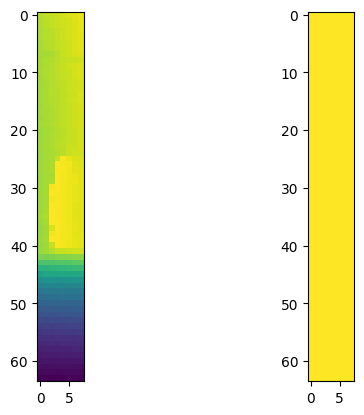

In [18]:
fig, ax = p.subplots(1,2)
# ax[0].imshow(testimg[:,:,0])
# ax[1].imshow(testimg[:,:,1], vmin=0, vmax=1)

# idx = 141
# ax[0].imshow(images[idx,:,:,0])
# ax[1].imshow(images[idx,:,:,1], vmin=0, vmax=1)

ax[0].imshow(testimg[:,:,0])
ax[1].imshow(testimg[:,:,1], vmin=0, vmax=1)

# print(images[idx,:,:,1])

(9599, 4, 4)


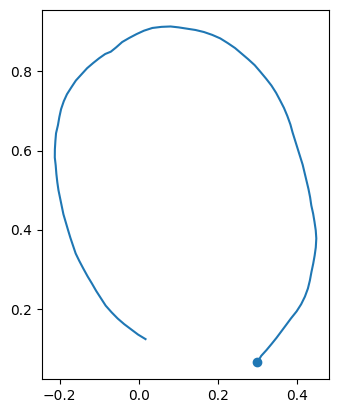

In [19]:
print(np.shape(poses))
fig, ax = p.subplots()
ax.scatter(-poses[0,1,-1],poses[0,2,-1])
ax.plot(-poses[:,1,-1],poses[:,2,-1])
ax.set_aspect("equal")

In [ ]:
#draw orientation of frames used for each patch in world frame
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]
for i in range(np.shape(images)[0]-1):
#     #convert depth image back to point cloud
#     count = 0
#     for w in range(np.shape(images)[1]):
#         for h in range(np.shape(images)[2]):
#             new_point_cloud_spherical[count,0] = images[i,w,h,0] #radius
#             new_point_cloud_spherical[count,1] = -(phimax-phimin)*(w/np.shape(images)[1]) #theta
#             new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(images)[2]) #phi
#             count+= 1
            
    #transform each to base frame using <poses>
    new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
    new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z -- does this indicate an error somewhere???

    #draw frames for each sub-scan 
    alph = 1-(i%(n_rots)/n_rots)
    #forward view direction (-z in NeRF c2w convention)
    headings = poses[i,:3,:3] @ np.array([0,0,-0.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "yellow", alpha = alph))
    # x
    headings = poses[i,:3,:3] @ np.array([.03,0,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "red", alpha = alph))
    #y
    headings = poses[i,:3,:3] @ np.array([0,.03,0])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "green", alpha = alph))
    #z
    headings = poses[i,:3,:3] @ np.array([0,0,.03])
    disp.append(Arrows(poses[i,:3,-1][None,:], (poses[i,:3,-1] + headings)[None,:], c = "blue", alpha = alph))
    
disp.append(Points(np.array([[0,0,0]]), r = 10, c = 'black'))
plt.show(disp, "Training Data Sample")
ViewInteractiveWidget(plt.window)

In [ ]:
print(np.shape(poses))
fig, ax = p.subplots()
ax.plot(poses[:,2,-1], poses[:,1,-1])
ax.set_aspect(1)

In [ ]:
#generate and visualize "dirs" points according to poses and patch specs

#OLD- USING SPHERICAL POINT PROJECTION

num_draw = 256 #128 #48 #number of patches to draw
N_samples = 64 #only when visualizing all test points

#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)

#test
vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True, sharecam = False) #axes = 4 (simple), 1(scale)
disp=[]

for count in range(num_draw):
    
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    look_at_pose = count
    c2w = poses[look_at_pose]
    c2w = tf.cast(c2w, tf.float32)
    near = 0.
    far = 64.
    
    #NOTE: not possible to infer phimin_temp/ phimax_temp from c2w matrix!
    
    #was this
#     phimin_temp = vertical_bins[count%n_vert_patches] 
#     phimax_temp = vertical_bins[count%n_vert_patches + 1]
    #test -- send bins from top to bottom
    phimin_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches+1)] 
    phimax_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches)]

    #reformat for LiDAR depth measurements ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    vert_fov = np.rad2deg(phimax-phimin)
    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
                          (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots), #for uninterpolated images
                          #phi
#                           (phimax + phimin)/2 + ((-j+31.5)/63)*(phimax-phimin) -np.pi/2 #single elevation patch
                        (phimax_temp + phimin_temp)/2 + ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp) -np.pi/2 #looks good but requries manually setting elevation angle
#                           (phimax + phimin)/2 + ((-j+(32//n_vert_patches))/(64//n_vert_patches))*((phimax - phimin)/n_vert_patches) - np.pi/2 #YES
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
#     dirs_test = LC.s2c(LC, dirs_test)    #was this
    dirs_test = spherical_to_cartesian(dirs_test)  #does the same thing
    
    #need to rotate red points into same frame as blue points 
    rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix()
    # Move rotm with crops rather than having to re-create crop process at render time? -- nope (spacing at tops and bottoms gets messed up)
#     rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax_temp + phimin_temp)/2,0]).as_matrix() 
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])

    dirs_test = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix() #looked good but converged slightly off
                          @ np.linalg.pinv(c2w[:3,:3]) )

    rotm_fix = (c2w[:3,:3] 
                @ np.linalg.pinv(c2w[:3,:3]))
    rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * rotm_fix, -1) #looks like I need to do this instead
    rays_o_test = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d_test))
    z_vals_test = tf.linspace(near, far, N_samples) 
    z_vals_test += tf.random.uniform(list(rays_o_test.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts_test = rays_o_test[...,None,:] + rays_d_test[...,None,:] * z_vals_test[...,:,None]
    pts_flat_test = tf.reshape(pts_test, [-1,3])

#     #random color
#     cname = np.array([255*(np.random.rand()), 255*(np.random.rand()), 255*(np.random.rand())]).T.tolist()
    #use depth as color
#     d = images[count,:,:,0].flatten()
    d = images[30*num_draw + count,:,:,0].flatten()
    cname = np.array([d/1.5, d/1.5, d/1.5]).T.tolist()

#     disp.append(Points(pts_flat_test, c = cname, r = 3, alpha = 0.5)) 
    disp.append(Points(dirs_test, c = cname, r = 3, alpha = 0.5))
#     disp.append(Points(dirs_test, c = 'pink', r = 3, alpha = 0.8))
#     disp.append(Points(dirs_test[:10], c = 'red', r = 5, alpha = 0.8))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames first pose
    #forward view direction (-z in NeRF c2w convention) 
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,-0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "yellow"))
    # x
    headings = poses[look_at_pose,:3,:3] @ np.array([0.3,0,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "red"))
    #y
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0.3,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "green"))
    #z
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "blue"))

plt.show(disp, "dirs", at = 0)
ViewInteractiveWidget(plt.window)

In [ ]:
#generate and visualize "dirs" points according to poses and patch specs

#TEST-- try using cylindrical point projection to generate dist

num_draw = 4 #128 #48 #number of patches to draw
N_samples = 64 #only when visualizing all test points

#Ouster OS1-64
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
# phimin = np.deg2rad(-6) 
# phimax = np.deg2rad(27.75)

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)

plt = Plotter(N = 1, axes = 0, bg = (1, 1, 1), interactive = True, sharecam = False) #axes = 4 (simple), 1(scale)
disp=[]

for count in range(num_draw):
    
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    look_at_pose = count
    c2w = poses[look_at_pose]
    c2w = tf.cast(c2w, tf.float32)
    near = 0.
    far = 2.
        
    #send bins from top to bottom
    phimin_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches+1)] 
    phimax_temp = vertical_bins[len(vertical_bins) -1 - (count%n_vert_patches)]

    #reformat for LiDAR depth measurements ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    vert_fov = np.rad2deg(phimax-phimin)
    #[r, theta, phi]
    dirs_test = tf.stack([-tf.ones_like(i), #r
                          #theta
                          (i - (1024//(2*n_rots)))  /(2048//(2*n_rots)) * (2*np.pi/n_rots) + np.pi, #for uninterpolated images
                          #phi
#                         #was this for spherical patches
#                           (phimax_temp + phimin_temp)/2 + ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp) -np.pi/2 #looks good but requries manually setting elevation angle
                          #test
                          (phimax_temp + phimin_temp)/2 - ((-j+(32//n_vert_patches))/(64//n_vert_patches))*(phimax_temp-phimin_temp) 
                         ], -1)
    dirs_test = tf.reshape(dirs_test,[-1,3])
#     dirs_test = LC.s2c(LC, dirs_test)    #was this
#     dirs_test = spherical_to_cartesian(dirs_test)  #does the same thing
    dirs_test = cylindrical_to_cartesian(dirs_test)  #test


    #need to rotate red points into same frame as blue points 
    rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax + phimin)/2,0]).as_matrix()
    # Move rotm with crops rather than having to re-create crop process at render time? -- nope (spacing at tops and bottoms gets messed up)
#     rotm = R.from_euler('xyz', [0,-np.pi/2 + (phimax_temp + phimin_temp)/2,0]).as_matrix() 
    dirs_test = dirs_test @ rotm
    dirs_test = dirs_test @ tf.transpose(c2w[:3,:3])
    # aligns dirs, doesn't get pts_flat to work yet
    dirs_test = dirs_test @ (c2w[:3,:3] 
                          @ R.from_euler('xyz', [0,0,np.pi/2]).as_matrix() #looked good but converged slightly off
                          @ np.linalg.pinv(c2w[:3,:3]) )

    rotm_fix = (c2w[:3,:3] 
                @ np.linalg.pinv(c2w[:3,:3]))
    rays_d_test = tf.reduce_sum(dirs_test[..., np.newaxis, :] * rotm_fix, -1) #looks like I need to do this instead
    rays_o_test = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d_test))
    z_vals_test = tf.linspace(near, far, N_samples) 
    z_vals_test += tf.random.uniform(list(rays_o_test.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    #[image_height, image_width, batch_size, 3]
    pts_test = rays_o_test[...,None,:] + rays_d_test[...,None,:] * z_vals_test[...,:,None]
    pts_flat_test = tf.reshape(pts_test, [-1,3])

    #random color
    cname = np.array([255*(np.random.rand()), 255*(np.random.rand()), 255*(np.random.rand())]).T.tolist()
    #use depth as color
# #     d = images[count,:,:,0].flatten()
#     d = images[30*num_draw + count,:,:,0].flatten()
#     cname = np.array([d/1.5, d/1.5, d/1.5]).T.tolist()
    
#     print(np.shape(pts_flat_test), np.shape(poses[count,-1,:3][:,None]))

    centered = pts_flat_test - poses[count,:3,-1]
    
#     disp.append(Points(pts_flat_test, c = cname, r = 3, alpha = 0.125)) 
#     disp.append(Points(centered, c = cname, r = 3, alpha = 0.125)) 
    disp.append(Points(dirs_test, c = cname, r = 3, alpha = 0.5))
#     disp.append(Points(dirs_test, c = 'pink', r = 3, alpha = 0.8))
#     disp.append(Points(dirs_test[:10], c = 'red', r = 5, alpha = 0.8))
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    #draw frames first pose
    #forward view direction (-z in NeRF c2w convention) 
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,-0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "yellow"))
    # x
    headings = poses[look_at_pose,:3,:3] @ np.array([0.3,0,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "red"))
    #y
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0.3,0])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "green"))
    #z
    headings = poses[look_at_pose,:3,:3] @ np.array([0,0,0.3])
    disp.append(Arrows(np.zeros([3,1]), (np.zeros([3,1]) + headings), c = "blue"))

plt.show(disp, "dirs", at = 0)
ViewInteractiveWidget(plt.window)

In [ ]:
#debug: view grid of patches
n_vert_patches = 8
view_scan_num = 8 #which scan to look at
num_view_rots = 10

fig, ax = p.subplots(n_vert_patches, num_view_rots)

for i in range(num_view_rots):
    for j in range(n_vert_patches):
        ax[j,i].imshow(images[num_draw*view_scan_num + j + i*n_vert_patches,:,:,0])#, vmin = 0, vmax = 1)
#         ax[j,i].imshow(np.flip(images[-(j + i*n_vert_patches),:,:,0], axis = 0), vmin = 0, vmax = 4)
        ax[j,i].get_xaxis().set_visible(False)
        ax[j,i].get_yaxis().set_visible(False)
        ax[j,i].set_aspect(W/H)
# p.subplots_adjust(wspace=0.1, hspace=0.1)

In [ ]:
## view patches (assumes sigle n_vert_patches == 1)
# %matplotlib notebook
fig, ax = p.subplots(2,5)
ax[0,0].set_title("depth image patches for training")

# ax[0,0].imshow(images[0,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[1,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[2,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[3,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[4,:,:,0])#, vmin=0, vmax=64)

# ax[0,0].imshow(images[-20,:,:,0])#, vmin=0, vmax=64)
# ax[0,1].imshow(images[-19,:,:,0])#, vmin=0, vmax=64)
# ax[0,2].imshow(images[-18,:,:,0])#, vmin=0, vmax=64)
# ax[0,3].imshow(images[-17,:,:,0])#, vmin=0, vmax=64)
# ax[0,4].imshow(images[-16,:,:,0])#, vmin=0, vmax=64)

ax[0,0].imshow(images[-4,:,:,0])#, vmin=0, vmax=64)
ax[0,1].imshow(images[-3,:,:,0])#, vmin=0, vmax=64)
ax[0,2].imshow(images[-2,:,:,0])#, vmin=0, vmax=64)
ax[0,3].imshow(images[-1,:,:,0])#, vmin=0, vmax=64)
ax[0,4].imshow(testimg[:,:,0])#, vmin=0, vmax=64)

ax[1,0].set_title("ray drop masks")
ax[1,0].imshow(images[-4,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,1].imshow(images[-3,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,2].imshow(images[-2,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,3].imshow(images[-1,:,:,1],cmap="gray", vmin=0,vmax=1)
ax[1,4].imshow(testimg[:,:,1],cmap="gray", vmin=0,vmax=1)

In [ ]:
phimin = np.deg2rad(-16) 
phimax = np.deg2rad(17.75)
print(phimin, phimax)

vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
print(vertical_bins, "\n")

for count in range(10):
    phimin_temp = vertical_bins[count%n_vert_patches] 
    phimax_temp = vertical_bins[(count)%n_vert_patches + 1]
    print(phimin_temp, phimax_temp)


# Animate GIF

In [58]:
num_frames = 50
num_view = 64 #128 #number of (rotational?) patches to draw
n_rots = 64 #128 #number of horizontal patches per 2*pi
n_vert_patches = 1 #number of vertical patches between phimin and phimax
N_samples = 128 #64 #does not have to match what was used in training?? 

H = 64
W = 1024 // n_rots

for i in range(num_frames):
    print(i)
    plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), offscreen=True)
    disp=[] 
    
    for j in range(num_view):
    # for j in np.linspace(0,7,15):
        #get sensor transformation matrix
        rotm = np.eye(4)

        # account for image crop in rotation -------------------
        #TODO-- will not work if using different focal length for elev/azim
        crop_angle =  -(np.pi/n_rots) + j*(2*np.pi/n_rots) #test
        rotm_crop = R.from_euler('xyz', [0,-crop_angle + np.pi/2,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ rotm_crop

        #also need to account for the fact that the LIDAR beam isn't actually centered at horizon
        sensor_elevation_zero_rotm = R.from_euler('xyz', [(phimin+phimax)/2,0,0]).as_matrix()
        rotm[:3,:3] = rotm[:3,:3] @ sensor_elevation_zero_rotm
        # ------------------------------------------------------

        # flip x and z axis
        rotm[0,-1], rotm[2,-1] = rotm[2,-1], rotm[0,-1] 

#         rotm[0:3,2] *= -1 # flip sign of y and z axis
#         rotm[0:3,1] *= -1
#         rotm = rotm[[1,0,2,3],:]
#         rotm[2,:] *= -1 # flip whole world upside down
#         rotm[2,-1] = 0.25 #x in world frame output
#         rotm[0,-1] = -0.0025 #- (i/3) #z in world frame output
#         rotm[1,-1] = -.25 #+ (i/6) #y in world frame
#         rotm = rotm.astype(np.float32)
        
        rotm[0:3,2] *= -1 # flip sign of y and z axis
        rotm[0:3,1] *= -1
        rotm = rotm[[1,0,2,3],:]
        rotm[2,:] *= -1 # flip whole world upside down
        rotm[2,-1] = 0.5 #4 #x in world frame output
        rotm[0,-1] = -0.005 #- (i/3) #z in world frame output
        rotm[1,-1] = -.25 + (i/100) #y in world frame
        rotm = rotm.astype(np.float32)

        phimin = np.deg2rad(-16) 
        phimax = np.deg2rad(17.75)
#         vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
#         phimin_patch = vertical_bins[img_i%n_vert_patches] 
#         phimax_patch = vertical_bins[img_i%n_vert_patches + 1]
#     #     print(phimin, phimax)
#     #     print(phimin_patch, phimax_patch)
#     #     phimin_patch = phimin #debug
#     #     phimax_patch = phimax #debug

#         #call NeRF using specified novel rotm
#         rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
#         depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=4., N_samples=N_samples)
#         new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
#         depth = tf.transpose(depth).numpy() #need this
#         depth = np.flip(depth, axis = 0) #needed

#         #scale back up to normal size
#         depth *= 20
#         ray_drop = tf.transpose(ray_drop).numpy() #test
#         ray_drop = np.flip(ray_drop, axis = 0) #test

#         #Ouster OS1-64
#         phimin = np.deg2rad(-16) 
#         phimax = np.deg2rad(17.75)

#         count = 0
#         for w in range(W):
#             for h in range(H):
#     #             #draw all points
#     #             new_point_cloud_spherical[count,0] = depth[w,h] #radius
#     #             suppress ray dropped points
#                 if ray_drop[w,h] > 0.95:
#                         new_point_cloud_spherical[count,0] = depth[w,h] #radius
#                 else:
#                         new_point_cloud_spherical[count,0] = 0#100
#                 new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)            
#                 #was this (for simulated data)
#                 #TODO: do I need to update this?
#                 new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
#                 count+= 1

#         new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #test

#         #if last square patch in sweep, throw away any points that wrap around origin
#         if j==11:
#             new_point_cloud_spherical= new_point_cloud_spherical[new_point_cloud_spherical[:,1]>=(-2*np.pi + (phimax-phimin))]

        vertical_bins = np.linspace(phimin, phimax, n_vert_patches+1)
        phimin_patch = vertical_bins[img_i%n_vert_patches] 
        phimax_patch = vertical_bins[img_i%n_vert_patches + 1]

        #call NeRF using specified novel rotm
        rays_o, rays_d = get_rays(H, W, rotm, phimin_patch, phimax_patch)
    #     depth, acc, ray_drop = render_rays(model, rays_o, rays_d, near=0., far=2., N_samples=N_samples)
        z_vals = tf.linspace(near, far, N_samples) 
        z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
        z_vals = z_vals[:,:,:,None]
        depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)

        #~~~~~~~~~~~
        #run fine pass through network
        fwd = np.append(np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), weights, axis = -1)
        rev = np.append(weights, np.zeros([np.shape(weights)[0], np.shape(weights)[1], 1]), axis = -1)
        fwd_test = np.max(sliding_window_view(fwd, window_shape = 2, axis = 2), axis = -1)
        rev_test = np.max(sliding_window_view(rev, window_shape = 2, axis = 2), axis = -1)
        test2 = (fwd_test + rev_test) /2 #blur
        test2 += 1/(3*N_samples) #shift up slightly
        test2 = test2 / np.sum(test2, axis = -1)[:,:,None] #renormalize
        cum_hist_vals = np.cumsum(test2, axis = -1)
        randy = np.sort(0.1*np.random.randn(N_samples*W*H)) 
        cum_hist_vals_flat = cum_hist_vals.flatten()
        step_corr = np.linspace(0,W*H-1,W*H)
        step_corr = np.tile(step_corr,(N_samples,1)).T
        step_corr = np.reshape(step_corr, [1,-1])[0,:]
        cum_hist_vals_flat+= step_corr
        linear_spaced = np.linspace(near, H*W, N_samples*H*W)
        ans = np.interp(x=linear_spaced, xp=cum_hist_vals_flat, fp=linear_spaced)
        ans -= step_corr
        ans *= 2
        ans = np.abs(ans)
        z_vals = np.reshape(ans, [H,W,N_samples,1])
        depth, acc, ray_drop, weights = render_rays(model, rays_o, rays_d,  z_vals)
        #~~~~~~~~~~~

        new_point_cloud_spherical = np.zeros([np.shape(depth)[0]*np.shape(depth)[1],3])
        depth = tf.transpose(depth).numpy() #need this
        depth = np.flip(depth, axis = 0) #needed

        #scale back up to normal size
        depth *= 50 #60 #20
        ray_drop = tf.transpose(ray_drop).numpy() #test
        ray_drop = np.flip(ray_drop, axis = 0) #test

        count = 0
        for w in range(W):
            for h in range(H):
    #             #draw all points
    #             new_point_cloud_spherical[count,0] = depth[w,h] #radius
    #             suppress ray dropped points
                if ray_drop[w,h] > 0.9:
                        new_point_cloud_spherical[count,0] = depth[w,h] #radius
                else:
                        new_point_cloud_spherical[count,0] = 0#100
                new_point_cloud_spherical[count,1] = (w-(1024//(2*n_rots)))/(2048//(2*n_rots))*(2*np.pi/n_rots)            

                new_point_cloud_spherical[count,2] = np.pi/2 + phimax - (phimax-phimin)*(h/np.shape(depth)[1]) #phi
                #test
    #             new_point_cloud_spherical[count,2] = (phimax_patch + phimin_patch)/2 + ((-h+(H/2))/(H))*(phimax_patch-phimin_patch) -np.pi/2

                count+= 1

        new_point_cloud_spherical[:,1] -= (np.pi/n_rots) - j*(2*np.pi/n_rots) #need this

        new_point_cloud_cart = LC.s2c(LC,new_point_cloud_spherical).numpy()
        new_point_cloud_cart[:,2] = -new_point_cloud_cart[:,2] #need to flip z 

        #translate to keep camera fixed in place
#         new_point_cloud_cart[:,0] += -3.5 + 15*i/30
        new_point_cloud_cart[:,0] += 1.5 + i/2
    
        # rainbow by z height
        zheight = 65*(np.sin(0.25*new_point_cloud_cart[:,2])+1)
        cname = np.array([1-zheight, zheight, 1.5*zheight]).T.tolist()
        disp.append(Points(new_point_cloud_cart, c = cname, r = 2., alpha = 0.5))
        
        
    cam = dict(
        pos=(37.30093, 95.07558, 94.30112),
        focalPoint=(8.715815, 0.7997105, -0.04585656),
        viewup=(-0.2068594, -0.6600254, 0.7222019),
        distance=136.4053,
        clippingRange=(53.80149, 240.4701),
    )

    plt.show(disp, "Novel Point Cloud From NeRF at [" 
             + str(np.round(-rotm[2,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[1,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[0,-1]*20, decimals=2)) + "]",
             camera= cam).screenshot("lidar_nerf_demo/Newer_College_V2_" + str(i) + ".png")
#     plt.show(disp, "Novel Point Cloud From NeRF at [" 
#              + str(np.round(-rotm[2,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[1,-1]*20, decimals=2)) + ", " + str(np.round(-rotm[0,-1]*20, decimals=2)) + "]").screenshot("lidar_nerf_demo/Newer_College_V2_" + str(i) + ".png")
    plt.clear()
    plt.close()
# ViewInteractiveWidget(plt.window)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


KeyboardInterrupt: 

# Remove motion distortion from raw point cloud data used to train NeRF

I believe directly training on motion-distorted raw point clouds is responsible for the "wiggly" motion of some walls observed in the rendered GIFs 

In [ ]:
#load HD Map
pl = '/media/derm/06EF-127D4/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]
plt = Plotter(N = 1, axes = 4, bg = (1, 1, 1), interactive = True)
disp=[]
disp.append(Points(submap, c = "gray", r = 2, alpha = 0.3)) 
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

In [ ]:
dir_name = "/media/derm/06EF-127D4/Newer College Dataset/"
experiment_name = "01_short_experiment-20230331T172433Z-009/01_short_experiment/"
fn_gt = dir_name + experiment_name + "ground_truth/registered_poses.csv"
# print(fn_gt)

#sec,nsec,x,y,z,qx,qy,qz,qw
gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)

seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
sensor_poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
sensor_poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
sensor_poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #was this --1134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32) #was this
sensor_poses = np.einsum("nij,jk->nik", sensor_poses, T_CL)
initial_pose = np.linalg.inv(sensor_poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
sensor_poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), sensor_poses)

# print(poses)

In [ ]:
idx = 905 #1450 #700    
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
fn2 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx +1) + ".npy"
pc1 = np.load(fn1)
pc2 = np.load(fn2)
# pc1 = np.flip(pc1, axis = 0)# uncomment to flip and maintain CCW convention used in VICET
# pc2 = np.flip(pc2, axis = 0)# uncomment to flip and maintain CCW convention used in VICET

In [ ]:
# %matplotlib notebook

#TODO: get body-frame euler angles from ground truth
fig, ax = p.subplots(4,2)
start_idx = 600
end_idx = 2000

ax[0,0].set_title("frames from ground truth")
ax[0,0].plot(poses[start_idx:end_idx,0,-1], poses[start_idx:end_idx,1,-1])
ax[0,0].set_aspect(1)

#plot velocity in world frame
vel_world_frame = np.diff(poses[:,:3,-1], axis = 0)
ax[1,0].set_title("x vel in world frame")
ax[1,0].plot(vel_world_frame[start_idx:end_idx,0])
ax[1,1].set_title("y vel in world frame")
ax[1,1].plot(vel_world_frame[start_idx:end_idx,1])

#get velocity in body frame
# rotm = R.from_euler('xyz',[0,0,3*np.pi/4]).as_matrix()
rotm = R.from_euler('xyz',[0,0,0]).as_matrix()
# vel_body_frame = poses[1:,:3,:3] @ rotm @ vel_world_frame[:,:,None]
vel_body_frame = np.linalg.pinv(poses[1:,:3,:3]) @ rotm @ vel_world_frame[:,:,None]

vel_body_frame = vel_body_frame[:,:,0]
ax[2,0].set_title("x vel body frame")
ax[2,0].plot(vel_body_frame[start_idx:end_idx,0])
ax[2,1].set_title("y vel body frame")
ax[2,1].plot(vel_body_frame[start_idx:end_idx,1])

#smooth out velocity estimates
def moving_average(a, n=10):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

window=50
MAx = moving_average(vel_body_frame[:,0], n = window)
ax[3,0].plot(MAx[start_idx:end_idx+window-1])
ax[3,0].set_title("smoothed x vel (body frame)")
MAy = moving_average(vel_body_frame[:,1], n = window)
ax[3,1].plot(MAy[start_idx:end_idx+window-1])
ax[3,1].set_title("smoothed y vel (body frame)")
MAz = moving_average(vel_body_frame[:,2], n = window)

vel_body_frame = np.array([MAx, MAy, MAz]).T

#plot heading on map
for i in range(start_idx,end_idx,100):
    heading = np.array([5,0,0]) @ np.linalg.pinv(poses[i, :3, :3]) @ rotm
    end = poses[i, :3, -1] + heading
    ax[0,0].plot([poses[i,0,-1], end[0]], [poses[i,1,-1], end[1]], color='red' )

    heading = np.array([0,5,0]) @ np.linalg.pinv(poses[i, :3, :3]) @ rotm
    end = poses[i, :3, -1] + heading
    ax[0,0].plot([poses[i,0,-1], end[0]], [poses[i,1,-1], end[1]], color='green' )

In [ ]:
#get rotational velocity
#get straight diff (was this)-- not going to work?
rot_vel_euls = np.diff(R.from_matrix(sensor_poses[:,:3,:3]).as_euler('xyz'), axis = 0)

# rot_vel_euls = np.zeros([len(poses)-1,3])
# for i in range(1,len(poses)):
#     pose_i_in_last_frame = np.linalg.pinv(poses[i-1,:3,:3]) @ poses[i,:3,:3]
#     end = R.from_matrix(sensor_pose_i_in_last_frame).as_euler('xyz')
#     rot_vel_euls[i-1] = end - R.from_matrix(poses[i-1,:3,:3]).as_euler('xyz')
# rot_vel_euls = np.diff(rot_vel_euls, axis = 0)

fig, ax = p.subplots(3)
ax[0].plot(rot_vel_euls[start_idx:end_idx,0])
ax[0].set_label("roll")
ax[1].plot(rot_vel_euls[start_idx:end_idx,1])
ax[1].set_label("pitch")
ax[2].plot(rot_vel_euls[start_idx:end_idx,2])
ax[2].set_label("yaw")

In [ ]:
from remove_motion_basic import linear_correction_old as lc
m_hat = np.array([vel_body_frame[idx,0],
                  vel_body_frame[idx,1],
                  vel_body_frame[idx,2],
                  rot_vel_euls[idx,0],
                  rot_vel_euls[idx,1],
                  rot_vel_euls[idx,2]
#                   0,0,0
                 ])
rectified_pc1 = lc(pc1, m_hat, period_lidar=1.)

pc1 = np.flip(pc1, axis = 0)# uncomment at the end to get image projection to work
rectified_pc1 = np.flip(rectified_pc1, axis = 0)# uncomment at the end to get image projection to work

In [ ]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

#transform map to pc1 frame (for debug)
submap_in_pc1_frame = (np.linalg.pinv(sensor_poses[idx]) @ initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
submap_in_pc1_frame = submap_in_pc1_frame[:,:3]

disp.append(Points(submap_in_pc1_frame, c = "black", r = 3, alpha = 0.1)) ##CB2314


# DRAW SCANS 1, 2
disp.append(Points(pc1, c = '#a65852', r = 3)) #red
# disp.append(Points(rectified_pc1, c = '#2c7c94', r = 3)) #blue
## purple -> green
color = 255*np.linspace(0,1,len(rectified_pc1)) 
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(rectified_pc1, c=cname,  r = 3.5, alpha =0.5))


plt.show(disp, "01 Short Experiment Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

In [ ]:
# print(np.rad2deg(R.from_quat([0.0, 0.0, 0.924, 0.383]).as_euler('xyz')))
# print(np.rad2deg(-np.pi/4 + np.pi/2))

fig, ax = p.subplots()
ax.set_title("frames from ground truth")
start_idx = 600
end_idx = 1000
ax.plot(sensor_poses[start_idx:end_idx,0,-1], sensor_poses[start_idx:end_idx,1,-1])
ax.set_aspect(1)